In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import cv2
import pandas as pd
import argparse
import shutil
import seaborn as sns
import json
import h5py
import glob
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

### Import scores 

In [4]:
root = "/home/mathiane/LNENWork/data_RoFormerMIL_TumorSegExp/dataRoFormer/results/task_3_tumor_carcinoids_segmentation/debug/label_frac=100/BTRoPEAMIL_s_pixel/training/2024-02-25_15-39-57"

In [13]:
list_res_test = glob.glob(f"{root}/patients_preds.parquet/*/*/*/*.parquet")
c = 0 
for path_res in list_res_test:
    df_res_c = pd.read_parquet(path_res)
    df_res_c["prob_non_tumor"] = df_res_c["probas"].values[0][0]
    df_res_c["prob_tumor"] = df_res_c["probas"].values[0][1]
    if c == 0:
        df_res = df_res_c     
    else:
        df_res = pd.concat([df_res, df_res_c])
    c +=1
df_res.head()

,slide_id,preds,labels,probas,prob_non_tumor,prob_tumor
0,TNE0531_T,1,1,"[0.13245843350887299, 0.8675415515899658]",0.132458,0.867542
0,TNE0870_N,0,0,"[0.8158934712409973, 0.1841064840555191]",0.815893,0.184106
0,TNE0060_T,1,1,"[0.1761041283607483, 0.8238958716392517]",0.176104,0.823896
0,TNE1100_N,0,0,"[0.8148276209831238, 0.18517237901687622]",0.814828,0.185172
0,TNE0058_N,0,0,"[0.8304222822189331, 0.1695777177810669]",0.830422,0.169578


In [23]:
tne_all = []
tne_id_tumor = []
tne_id_non_tumor = []
for ele in list(df_res["slide_id"]):
    tne_id = ele.split("_")[0]
    tne_all.append(tne_id)
    if ele.split("_")[1] == "T":
        tne_id_tumor.append(tne_id)
    else:
        tne_id_non_tumor.append(tne_id)
    


In [22]:
set(tne_id_tumor).intersection(set(tne_id_non_tumor))

{'TNE0360',
 'TNE0541',
 'TNE0886',
 'TNE0969',
 'TNE1003',
 'TNE1087',
 'TNE1095',
 'TNE1490'}

In [24]:
df_res["TNEID"] = tne_all

In [25]:
df_res[df_res["TNEID"].isin(set(tne_id_tumor).intersection(set(tne_id_non_tumor)))]

,slide_id,preds,labels,probas,prob_non_tumor,prob_tumor,TNEID
0,TNE1003_T,1,1,"[0.1609242558479309, 0.8390757441520691]",0.160924,0.839076,TNE1003
0,TNE0969_N,0,0,"[0.8705697059631348, 0.12943023443222046]",0.870570,0.129430,TNE0969
0,TNE0541_T,1,1,"[0.12759827077388763, 0.872401773929596]",0.127598,0.872402,TNE0541
0,TNE0360_T,1,1,"[0.3808956742286682, 0.6191043257713318]",0.380896,0.619104,TNE0360
0,TNE0360_N,0,0,"[0.8639090657234192, 0.13609088957309723]",0.863909,0.136091,TNE0360
0,TNE1003_N,0,0,"[0.6808785796165466, 0.3191213607788086]",0.680879,0.319121,TNE1003
0,TNE1490_N,0,0,"[0.6687450408935547, 0.3312549293041229]",0.668745,0.331255,TNE1490
0,TNE0886_N,0,0,"[0.9245175123214722, 0.07548251003026962]",0.924518,0.075483,TNE0886
0,TNE1087_T,1,1,"[0.004857966210693121, 0.9951419830322266]",0.004858,0.995142,TNE1087
0,TNE1490_T,1,1,"[0.016737207770347595, 0.9832627773284912]",0.016737,0.983263,TNE1490


In [15]:
print(roc_auc_score(df_res['labels'], df_res['prob_tumor']))

0.9939446366782007


## Create one heatmap

### Import attention scores

In [409]:
sample= "TNE0531"

In [410]:
attn_scores_non_tumor = h5py.File(glob.glob(f"{root}/attention_scores/*/{sample}_N.h5")[0], 'r')

In [411]:
attn_scores_non_tumor_coords = attn_scores_non_tumor.get("coords").value


/home/mathiane/miniconda3/envs/HaloAE/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.


In [412]:
attn_scores_non_tumor = attn_scores_non_tumor.get("attention_scores").value*10000

/home/mathiane/miniconda3/envs/HaloAE/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.


In [413]:
attn_scores_non_tumor_avg = attn_scores_non_tumor[0,:,:].transpose().mean(axis=1)#.shape

In [414]:
attn_scores_non_tumor = h5py.File(glob.glob(f"{root}/attention_scores/*/{sample}_N.h5")[0], 'r')


In [415]:
attn_scores_non_tumor_coords[:,0].shape

(11991,)

In [416]:
Attn_scores_NonTumor = pd.DataFrame({"x_rank":attn_scores_non_tumor_coords[:,0],
             "y_rank":attn_scores_non_tumor_coords[:,1], 
             "attn_scores_avg": attn_scores_non_tumor_avg,
            "label": np.repeat("NonTumor", attn_scores_non_tumor_coords[:,0].shape[0])})

In [417]:
attn_scores_tumor = h5py.File(glob.glob(f"{root}/attention_scores/*/{sample}_T.h5")[0], 'r')

In [418]:
attn_scores_tumor_coords = attn_scores_tumor.get("coords").value
attn_scores_tumor = attn_scores_tumor.get("attention_scores").value*10000
attn_scores_tumor_avg = attn_scores_tumor[0,:,:].transpose().mean(axis=1)

/home/mathiane/miniconda3/envs/HaloAE/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.
/home/mathiane/miniconda3/envs/HaloAE/lib/python3.6/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [419]:
Attn_scores_Tumor = pd.DataFrame({"x_rank":attn_scores_tumor_coords[:,0],
             "y_rank":attn_scores_tumor_coords[:,1], 
             "attn_scores_avg": attn_scores_tumor_avg,
             "label": np.repeat("Tumor", attn_scores_tumor_coords[:,0].shape[0])})

In [420]:
Attn_scores= pd.concat([Attn_scores_Tumor, Attn_scores_NonTumor]).reset_index()

In [421]:
Attn_scores.head()

,index,x_rank,y_rank,attn_scores_avg,label
0,0,0,994,0.503541,Tumor
1,1,1,803,0.503605,Tumor
2,2,1,898,0.503615,Tumor
3,3,1,994,0.503365,Tumor
4,4,1,1103,0.503367,Tumor


In [422]:
Attn_scores[Attn_scores["label"] == "Tumor"].shape

(19863, 5)

In [423]:
Attn_scores[Attn_scores["label"] == "Tumor"]

,index,x_rank,y_rank,attn_scores_avg,label
0,0,0,994,0.503541,Tumor
1,1,1,803,0.503605,Tumor
2,2,1,898,0.503615,Tumor
3,3,1,994,0.503365,Tumor
4,4,1,1103,0.503367,Tumor
...,...,...,...,...,...
19858,19858,19858,11068,0.503496,Tumor
19859,19859,19859,11068,0.503512,Tumor
19860,19860,19859,11594,0.503313,Tumor
19861,19861,19861,8531,0.503516,Tumor


In [424]:
Attn_scores[Attn_scores["label"] == "NonTumor"].shape

(11991, 5)

In [425]:
Attn_scores[Attn_scores["label"] == "NonTumor"]

,index,x_rank,y_rank,attn_scores_avg,label
19863,0,0,1492,0.834557,NonTumor
19864,1,1,733,0.834394,NonTumor
19865,2,2,672,0.833838,NonTumor
19866,3,3,861,0.834044,NonTumor
19867,4,3,979,0.833642,NonTumor
...,...,...,...,...,...
31849,11986,11985,4237,0.833785,NonTumor
31850,11987,11985,4301,0.833401,NonTumor
31851,11988,11985,4662,0.834690,NonTumor
31852,11989,11985,4721,0.835029,NonTumor


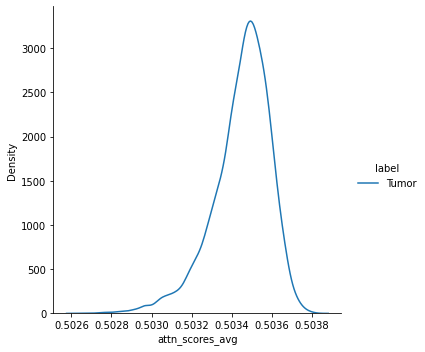

In [426]:
sns.displot(data=Attn_scores[Attn_scores["label"]=="Tumor"], x="attn_scores_avg", hue = "label", kind="kde")

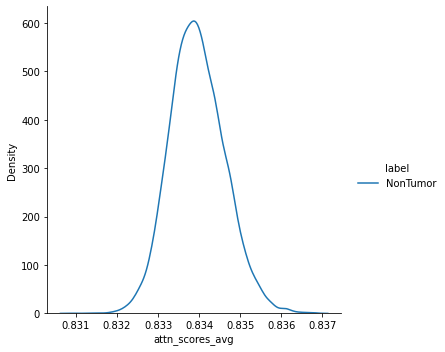

In [427]:
sns.displot(data=Attn_scores[Attn_scores["label"]=="NonTumor"], x="attn_scores_avg", hue = "label", kind="kde")

### Get coords table

In [428]:
Coords_root_folder = "/home/mathiane/LNENWork/data_RoFormerMIL_TumorSegExp/coords_table"

In [429]:
Coords_non_tumor_path = os.path.join(Coords_root_folder, "NonTumor", f"{sample}_N_coords.csv")
Coords_tumor_path = os.path.join(Coords_root_folder, "Tumor", f"{sample}_T_coords.csv")

Coords_non_tumor = pd.read_csv(Coords_non_tumor_path)
Coords_non_tumor["label"] = np.repeat("NonTumor", Coords_non_tumor.shape[0])
Coords_tumor = pd.read_csv(Coords_tumor_path)
Coords_tumor["label"] = np.repeat("Tumor", Coords_tumor.shape[0])


In [430]:
Coords = pd.concat([Coords_tumor,Coords_non_tumor ])

In [431]:
Attn_scores = pd.merge(Coords, Attn_scores,  how='left', left_on=['label','x_rank', 'y_rank'], right_on = ['label','x_rank', 'y_rank'])

In [432]:
Attn_scores.head()

,img_id_c,x,y,x_rank,y_rank,label,index,attn_scores_avg
0,TNE0531_3073_12673,3073.0,12673,0,994,Tumor,0,0.503541
1,TNE0531_3457_11905,3457.0,11905,1,803,Tumor,1,0.503605
2,TNE0531_3457_12289,3457.0,12289,1,898,Tumor,2,0.503615
3,TNE0531_3457_12673,3457.0,12673,1,994,Tumor,3,0.503365
4,TNE0531_3457_13057,3457.0,13057,1,1103,Tumor,4,0.503367


### Load parameters for tiles

In [433]:
rootdir = '/home/mathiane/LNENWork/PathonetCombinedDataSet2/PredBreastLNENDataset2Epoch50'
args = dict()
args['sample'] = sample
args['folder_tumoral_tiles'] ='/home/mathiane/LNENWork/Tiles_HE_all_samples_384_384_Vahadane_2'
args['folder_WSI_jpg'] =  '/home/mathiane/LNENWork/FullSlidesToJpeg'


In [434]:
Q1 = Attn_scores["attn_scores_avg"].quantile(0.1)
Q9 = Attn_scores["attn_scores_avg"].quantile(0.9)

# Split DataSet by sample's name

In [435]:
path_main_TNE = args["folder_tumoral_tiles"]
for f in os.listdir(path_main_TNE):
    if f.find(args['sample']) != -1:
        folder_name = f
        break
folder_name

'TNE0531.svs'

In [436]:
outputdir = '/home/mathiane/LNENWork/data_RoFormerMIL_TumorSegExp/dataRoFormer/results/task_3_tumor_carcinoids_segmentation/debug/label_frac=100/BTRoPEAMIL_s_pixel/HeatMaps'

In [437]:
os.makedirs(os.path.join(outputdir, sample), exist_ok = True)

In [438]:
sample

'TNE0531'

In [439]:
sample_maxX_maxY = {}
path_main_TNE = args["folder_tumoral_tiles"]#args.path_tne_tiles
sample = sample

sample_folder = os.path.join(path_main_TNE, folder_name)

xmax = 0
ymax = 0
for folder in os.listdir(sample_folder):
    tiles_p = os.path.join(path_main_TNE, folder_name, folder)
    for tiles_l in os.listdir(tiles_p):
        xmax_c = int(tiles_l.split('_')[1])
        ymax_c  = int(tiles_l.split('_')[2].split('.')[0])
        if xmax < xmax_c:
            xmax = xmax_c
        else:
            xmax = xmax
        if ymax < ymax_c:
            ymax = ymax_c
        else:
            ymax = ymax

sample_maxX_maxY[sample] = [xmax, ymax]
sample_maxX_maxY
    

{'TNE0531': [100993, 93697]}

In [440]:
from scipy import stats

In [441]:
im_size = 384

In [442]:
full_LNEN_WSI = args['folder_WSI_jpg']
for f in  os.listdir(full_LNEN_WSI):

    if f.find(args['sample'][:7]) != -1:
        folder_name_full_size = f
        break

In [443]:
folder_name_full_size

'TNE0531.jpg'

In [444]:
Attn_scores["x"].max()

100993.0

In [445]:
Attn_scores["y"].max()

93697

In [446]:
for k in sample_maxX_maxY.keys():
    w =  tuple(sample_maxX_maxY[k])[0] + im_size
    h = tuple(sample_maxX_maxY[k])[1] + im_size        
    seq = im_size
    W = len(list(range(1, w, seq)))
    H = len(list(range(1, h, seq)))
    
    mat_prob_atypical =   np.empty((W*10, H*10))#-1
    mat_prob_atypical[:] =  np.NaN
    
    mat_prob_binary = np.empty((W*10, H*10))
    mat_prob_binary[:] =  np.NaN
        
df_test_pred_s = Attn_scores
        

In [447]:
df_test_pred_s.head()

,img_id_c,x,y,x_rank,y_rank,label,index,attn_scores_avg
0,TNE0531_3073_12673,3073.0,12673,0,994,Tumor,0,0.503541
1,TNE0531_3457_11905,3457.0,11905,1,803,Tumor,1,0.503605
2,TNE0531_3457_12289,3457.0,12289,1,898,Tumor,2,0.503615
3,TNE0531_3457_12673,3457.0,12673,1,994,Tumor,3,0.503365
4,TNE0531_3457_13057,3457.0,13057,1,1103,Tumor,4,0.503367


In [448]:
[args["sample"]]

['TNE0531']

In [449]:
Path2Image = []
PredTumorNomal = []
loss_t = "Attention_scores"
for k in sample_maxX_maxY.keys():
    if k in [args["sample"]]:    
        for i in range(df_test_pred_s.shape[0]):
            x_ = int(df_test_pred_s.iloc[i,:]['x'])
            y_ = int(df_test_pred_s.iloc[i,:]['y'])
            
            Path2Image.append(df_test_pred_s.iloc[i,:]['img_id_c'])
            
            mat_prob_atypical[x_ // im_size * 10 :x_ // im_size *10 + 10 ,  y_ // im_size * 10 :y_ // im_size * 10 + 10 ]= df_test_pred_s.iloc[i,df_test_pred_s.columns.get_loc('attn_scores_avg')]
  
            
        if k.find('TNE') != -1:
            get_full_img = full_LNEN_WSI + "/" +folder_name_full_size
            print('get_full_img  ', get_full_img)

        im = cv2.imread(get_full_img)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        fig=plt.figure(1,figsize=(8,8))
        plt.imshow(im.astype('uint8'))

        print(outputdir, k+'_RoFormerMIL_','WSI_{}.png'.format(k))
        plt.title('WSI_{}'.format(k))
        fig.savefig(os.path.join(outputdir, k,'WSI_{}.png'.format(k)), dpi=fig.dpi)
        plt.close()

        #tiles heat map sans normalisation
        
        color_map = plt.cm.get_cmap('coolwarm')
        fig=plt.figure(2,figsize=(8,8))
        plt.matshow(mat_prob_atypical,  cmap=color_map,
                    interpolation='none',  fignum=2, vmin=Q1, 
                    vmax =Q9)
        mtitle = 'Normal tiles scores sample {} '.format(k)
        plt.title(mtitle)
        plt.colorbar()
        fig.savefig(os.path.join(outputdir, k,'Normality_tiles_accept_reject_map_minmaxnorm_{}_{}.png'.format(k, loss_t)), dpi=fig.dpi)
        plt.colorbar()
        plt.close()
                
       
        
        color_map = plt.cm.get_cmap('coolwarm')
        fig=plt.figure(4,figsize=(8,8))
        plt.matshow(mat_prob_atypical,  cmap=color_map,
                    interpolation='none',  fignum=4)
        mtitle = 'Normal tiles scores sample {} '.format(k)
        plt.title(mtitle)
        plt.colorbar()
        fig.savefig(os.path.join(outputdir, k,'Normality_tiles_accept_reject_map_{}_{}.png'.format(k, loss_t)), dpi=fig.dpi)
        plt.colorbar()
        plt.close()
    

get_full_img   /home/mathiane/LNENWork/FullSlidesToJpeg/TNE0531.jpg
/home/mathiane/LNENWork/data_RoFormerMIL_TumorSegExp/dataRoFormer/results/task_3_tumor_carcinoids_segmentation/debug/label_frac=100/BTRoPEAMIL_s_pixel/HeatMaps TNE0531_RoFormerMIL_ WSI_TNE0531.png


In [450]:
sample

'TNE0531'

Copy paste dans un nouveau folder qui regroupe les images avec le meilleur score, juste pour voir si le tri a bien ete fait

In [428]:
os.makedirs(os.path.join(outputdir, k+'_heatMap','MostDiscrimiant'), exist_ok = True)

In [429]:
os.makedirs(os.path.join(outputdir, k+'_heatMap','LessDiscrimiant'), exist_ok=True)

In [430]:
df_test_pred_s = df_test_pred_s.sort_values('lossnorm_max')

In [431]:
for ele in list(df_test_pred_s['Path2Image'][:20]):
    nname  = '/home/mathiane/LNENWork' + ele[29:]
    shutil.copy('/home/mathiane/LNENWork' + ele[29:], os.path.join(outputdir, k+'_heatMap','MostDiscrimiant'))

In [432]:
df_test_pred_s = df_test_pred_s.sort_values('lossnorm_max', ascending = False)
for ele in list(df_test_pred_s['Path2Image'][:20]):
    nname  = '/home/mathiane/LNENWork' + ele[29:]
    shutil.copy('/home/mathiane/LNENWork' + ele[29:], os.path.join(outputdir, k+'_heatMap','LessDiscrimiant'))